In [22]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

from exotic_ld import StellarLimbDarkening

import pandas as pd
import pickle

import celerite2
from celerite2 import terms

In [23]:
def set_params(params, guess_flux, yerrs):
    """
    Creating a GaussianProcess object for a Matern32Term kernel. 

    Parameters
    ----------
    params : array_like
        Containing Matern32Term kernel parameters.
        _sigma, _rho = params 
    
    guess_flux : array_like
        Containing the physical (batman) model flux.
    
    yerrs : array_like
        Containing an array of flux errors from TESS observations.

    Returns
    -------
    gp : GaussianProcess
        GaussianProcess object.

    """
    _sigma, _rho = params
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=guess_flux)
    gp.compute(t, yerr=yerrs, quiet=True)

    return gp

In [24]:
TIC = 'TIC 420779000' #HAT-P-26b / TIC 420779000

search_result = lk.search_lightcurve(
    target=TIC,
    mission='TESS', author='SPOC')
print("trying to download")
lc_collection = search_result.download_all()
print("Search done")
print(lc_collection)
lc = lc_collection.stitch(corrector_func=lambda x: x.
                          remove_nans().normalize(unit='unscaled'))

lc = lc.remove_nans()

trying to download
Search done
LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 420779000" SECTOR=50 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [25]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2665.276621666103,1.0008752e+00,1.6877042e-03,5.0983941e-03,1035228,1712.50806,1864.32177,6.1302373e+03,1.0319491e+01,1.5157616e+03,3.7660410e+00,7.1721631e+03,1.2093904e+01,0,———,———,———,———,1712.50806,1.3248915e-03,1864.32177,1.3110075e-03,-3.7879929e-02,1.0244901e-01
2665.2780106009227,9.9939626e-01,1.6885798e-03,5.0984407e-03,1035229,1712.51308,1864.32094,6.1227061e+03,1.0324845e+01,1.5224823e+03,3.7810454e+00,7.1615649e+03,1.2100179e+01,0,———,———,———,———,1712.51308,1.3261628e-03,1864.32094,1.3112831e-03,-3.2004643e-02,1.0131135e-01
2665.2793995357433,9.9927253e-01,1.6881203e-03,5.0984873e-03,1035230,1712.51125,1864.31516,6.1217334e+03,1.0322036e+01,1.5206570e+03,3.7757792e+00,7.1606782e+03,1.2096887e+01,0,———,———,———,———,1712.51125,1.3261768e-03,1864.31516,1.3103712e-03,-3.7128687e-02,9.5918149e-02
2665.2807884705635,1.0043720e+00,1.6912979e-03,5.0985338e-03,1035231,1712.50948,1864.32062,6.1531748e+03,1.0341465e+01,1.5216674e+03,3.7705452e+00,7.1972202e+03,1.2119657e+01,0,———,———,———,———,1712.50948,1.3216167e-03,1864.32062,1.3083346e-03,-3.4576565e-02,1.0225669e-01
2665.2821774058493,1.0007608e+00,1.6884294e-03,5.0985808e-03,1035232,1712.50742,1864.31755,6.1306606e+03,1.0323926e+01,1.5226661e+03,3.7688382e+00,7.1713428e+03,1.2099101e+01,0,———,———,———,———,1712.50742,1.3256199e-03,1864.31755,1.3087012e-03,-3.8559388e-02,1.0009597e-01
2665.2835663406704,9.9956930e-01,1.6884031e-03,5.0986274e-03,1035233,1712.51242,1864.31983,6.1226650e+03,1.0323764e+01,1.5179741e+03,3.7734630e+00,7.1628047e+03,1.2098912e+01,0,———,———,———,———,1712.51242,1.3269043e-03,1864.31983,1.3105640e-03,-3.4752984e-02,1.0057126e-01
2665.2849552754915,9.9820203e-01,1.6865281e-03,5.0986740e-03,1035234,1712.50889,1864.31878,6.1138428e+03,1.0312301e+01,1.5209933e+03,3.7675910e+00,7.1530068e+03,1.2085477e+01,0,———,———,———,———,1712.50889,1.3263194e-03,1864.31878,1.3127550e-03,-3.9159257e-02,1.0016379e-01
2665.2863442103117,9.9677658e-01,1.6860449e-03,5.0987205e-03,1035235,1712.51207,1864.32187,6.1045146e+03,1.0309346e+01,1.5252603e+03,3.7711377e+00,7.1427925e+03,1.2082014e+01,0,———,———,———,———,1712.51207,1.3281615e-03,1864.32187,1.3129751e-03,-3.5147920e-02,1.0174066e-01


In [26]:
#Removing an outlier

t = []
flux_data = []
yerrs = []

for time, flux, yerr in zip(lc.time.btjd, lc.flux, lc.flux_err):
    if flux <= 1.014: #Include fluxes below or equal to this value
        t.append(time)
        flux_data.append(flux)
        yerrs.append(yerr)

t = np.array(t)
flux_data = np.array(flux_data)
yerrs = np.array(yerrs)

In [27]:
lc_new = lk.LightCurve(time=t, flux=flux_data)

In [48]:
lk_binned = lc_new.bin(time_bin_size=0.01388888) #0.00694444 days = 10 minute bin size
#0.01388888 day = 20 minute bin size 
lc_binned_time = np.array(lk_binned.time.value)
lc_binned_flux = np.array(lk_binned.flux)

In [50]:
lc_binned_time, lc_binned_flux

(array([2665.28356611, 2665.29745499, 2665.31134387, ..., 2691.49188267,
        2691.50577155, 2691.51966043]),
 array([0.99975729, 0.99910164, 0.99961299, ..., 1.00025439, 1.0005219 ,
        1.00033271]))

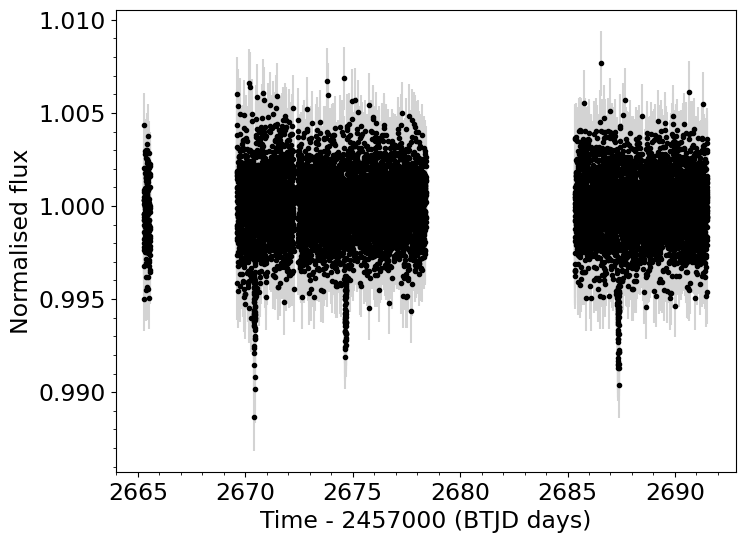

In [29]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.errorbar(t, flux_data, yerrs, fmt='.', color='Black', ecolor='LightGrey')


plt.ylabel("Normalised flux", size=17)
plt.xlabel("Time - 2457000 (BTJD days)", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()

In [30]:
filename = "HAT_P_26b_free_ecc_gp_batman_flat_samples.p"
with open(filename, "rb") as f:
    flat_samples = pickle.load(f)
f.close()

In [31]:
#batman model
model_T0 = np.percentile(flat_samples[:, 0], 50) #Mid-transit time (Days)
model_Rp = np.percentile(flat_samples[:, 1], 50) #Rp/Rs
model_per = np.percentile(flat_samples[:, 2], 50) #Orbital period (Days)
model_inc = np.percentile(flat_samples[:, 3], 50) #Orbital inclination (Deg)
model_a = np.percentile(flat_samples[:, 4], 50) #a/R*
model_ecc = np.percentile(flat_samples[:, 5], 50) #Eccentricity

#GP model
model_sigma = np.percentile(flat_samples[:, 6], 50)
model_rho = np.percentile(flat_samples[:, 7], 50)

prior_Rs = 0.8564404 #R_sun, Gaia DR2

model_params = batman.TransitParams()
model_params.t0 = model_T0
model_params.per = model_per
model_params.rp = model_Rp
model_params.a = model_a
model_params.inc = model_inc
model_params.ecc = model_ecc
model_params.w = 46.0 #Knutson et al. 2014
model_params.limb_dark = "quadratic"
model_params.u = [0.35092681757927346, 0.22991353177818383] #Estimated from WASP_39b_ldc.ipynb

m = batman.TransitModel(model_params, t) #Use TESS time series, t
batman_model = m.light_curve(model_params)

In [32]:
gp = set_params([model_sigma, model_rho], batman_model, yerrs)

filename = "HAT_P_26b_model_flux.p"

if os.path.exists(filename) == True:
    with open(filename, "rb") as f:
        t_none, model_flux = pickle.load(f)
    f.close()
else:
    print("Not loading")

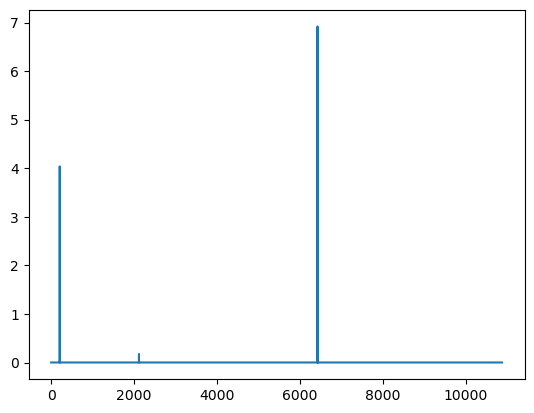

In [33]:
plt.plot(np.diff(t))

In [34]:
time_stamp = []
for i, time in zip(range(len(t)), np.diff(t)):
    if time > 0.1:
        print(t[i], t[i+1], time, i)
        time_stamp.append([t[i], t[i+1]])

2665.5641310453957 2669.601764978378 4.037633932982317 207
2672.2560162413984 2672.432410508626 0.17639426722780627 2117
2678.407564258343 2685.3256978950176 6.918133636674611 6420


In [35]:
 #0.001388889 days = 2 minutes

t_range = np.array([0.0])
for t1, t2 in time_stamp:
    t_range = np.append(t_range, np.arange(t1, t2, 0.001388889))

t_range = np.delete(t_range, 0)

t_range_m = batman.TransitModel(model_params, t_range) #Use TESS time series, t
batman_model_extend_range = t_range_m.light_curve(model_params)

In [36]:
t_model = np.append(t_none, t_range)
flux_model = np.append(model_flux, batman_model_extend_range)
print(t_model)
print(flux_model)

[2665.27662167 2665.2780106  2665.27939954 ... 2685.32284259 2685.32423148
 2685.32562037]
[0.99989082 0.99988992 0.99988903 ... 1.         1.         1.        ]


In [37]:
temp_model_flux = np.stack((t_model, flux_model), axis=-1)
temp_model_flux = temp_model_flux[temp_model_flux[:, 0].argsort(kind='mergesort')]

In [38]:
new_model_t = temp_model_flux[:, 0]
new_model_flux = temp_model_flux[:, 1]

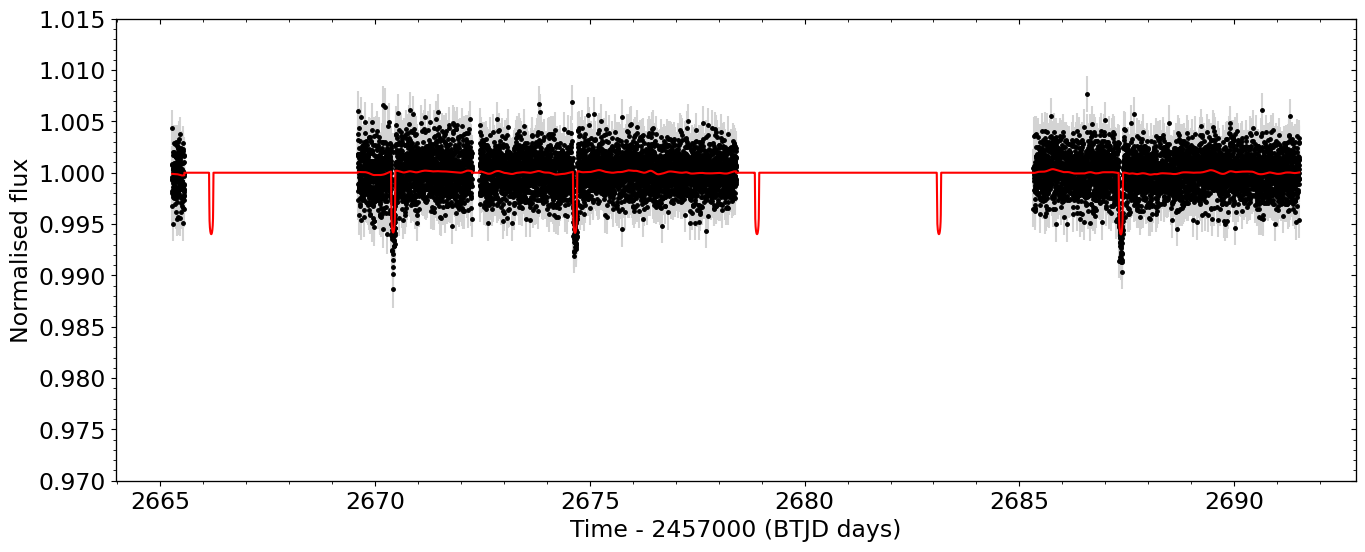

In [39]:
#batman + gp model
ylim = [0.97, 1.015]
fig, ax = plt.subplots(1, figsize=(16,6))

ax.errorbar(t, flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0) #Black
ax.plot(new_model_t, new_model_flux, color='Red', zorder=10)


# ax.set_xlim([min(t) - 1, max(t) + 1])
ax.set_ylim(ylim)
ax.set_ylabel("Normalised flux", size=17)
ax.set_xlabel("Time - 2457000 (BTJD days)", size=17)

# Mirror y
axA = ax.twinx()
axA.set_ylim(ax.get_ylim())
axA.get_yaxis().set_ticklabels([])
axA.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
axB = ax.twiny()
axB.set_xlim(ax.get_xlim())
axB.get_xaxis().set_ticklabels([])
axB.tick_params(which="both", direction="in")

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

#Enabling Minor ticks
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
axB.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
axA.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()

In [40]:
# filename = "HAT_P_26b_model_flux_full_range.p"

# file = open(filename, "wb")
# pickle.dump([new_model_t, new_model_flux], file)
# file.close()

In [41]:
residuals = flux_data - model_flux

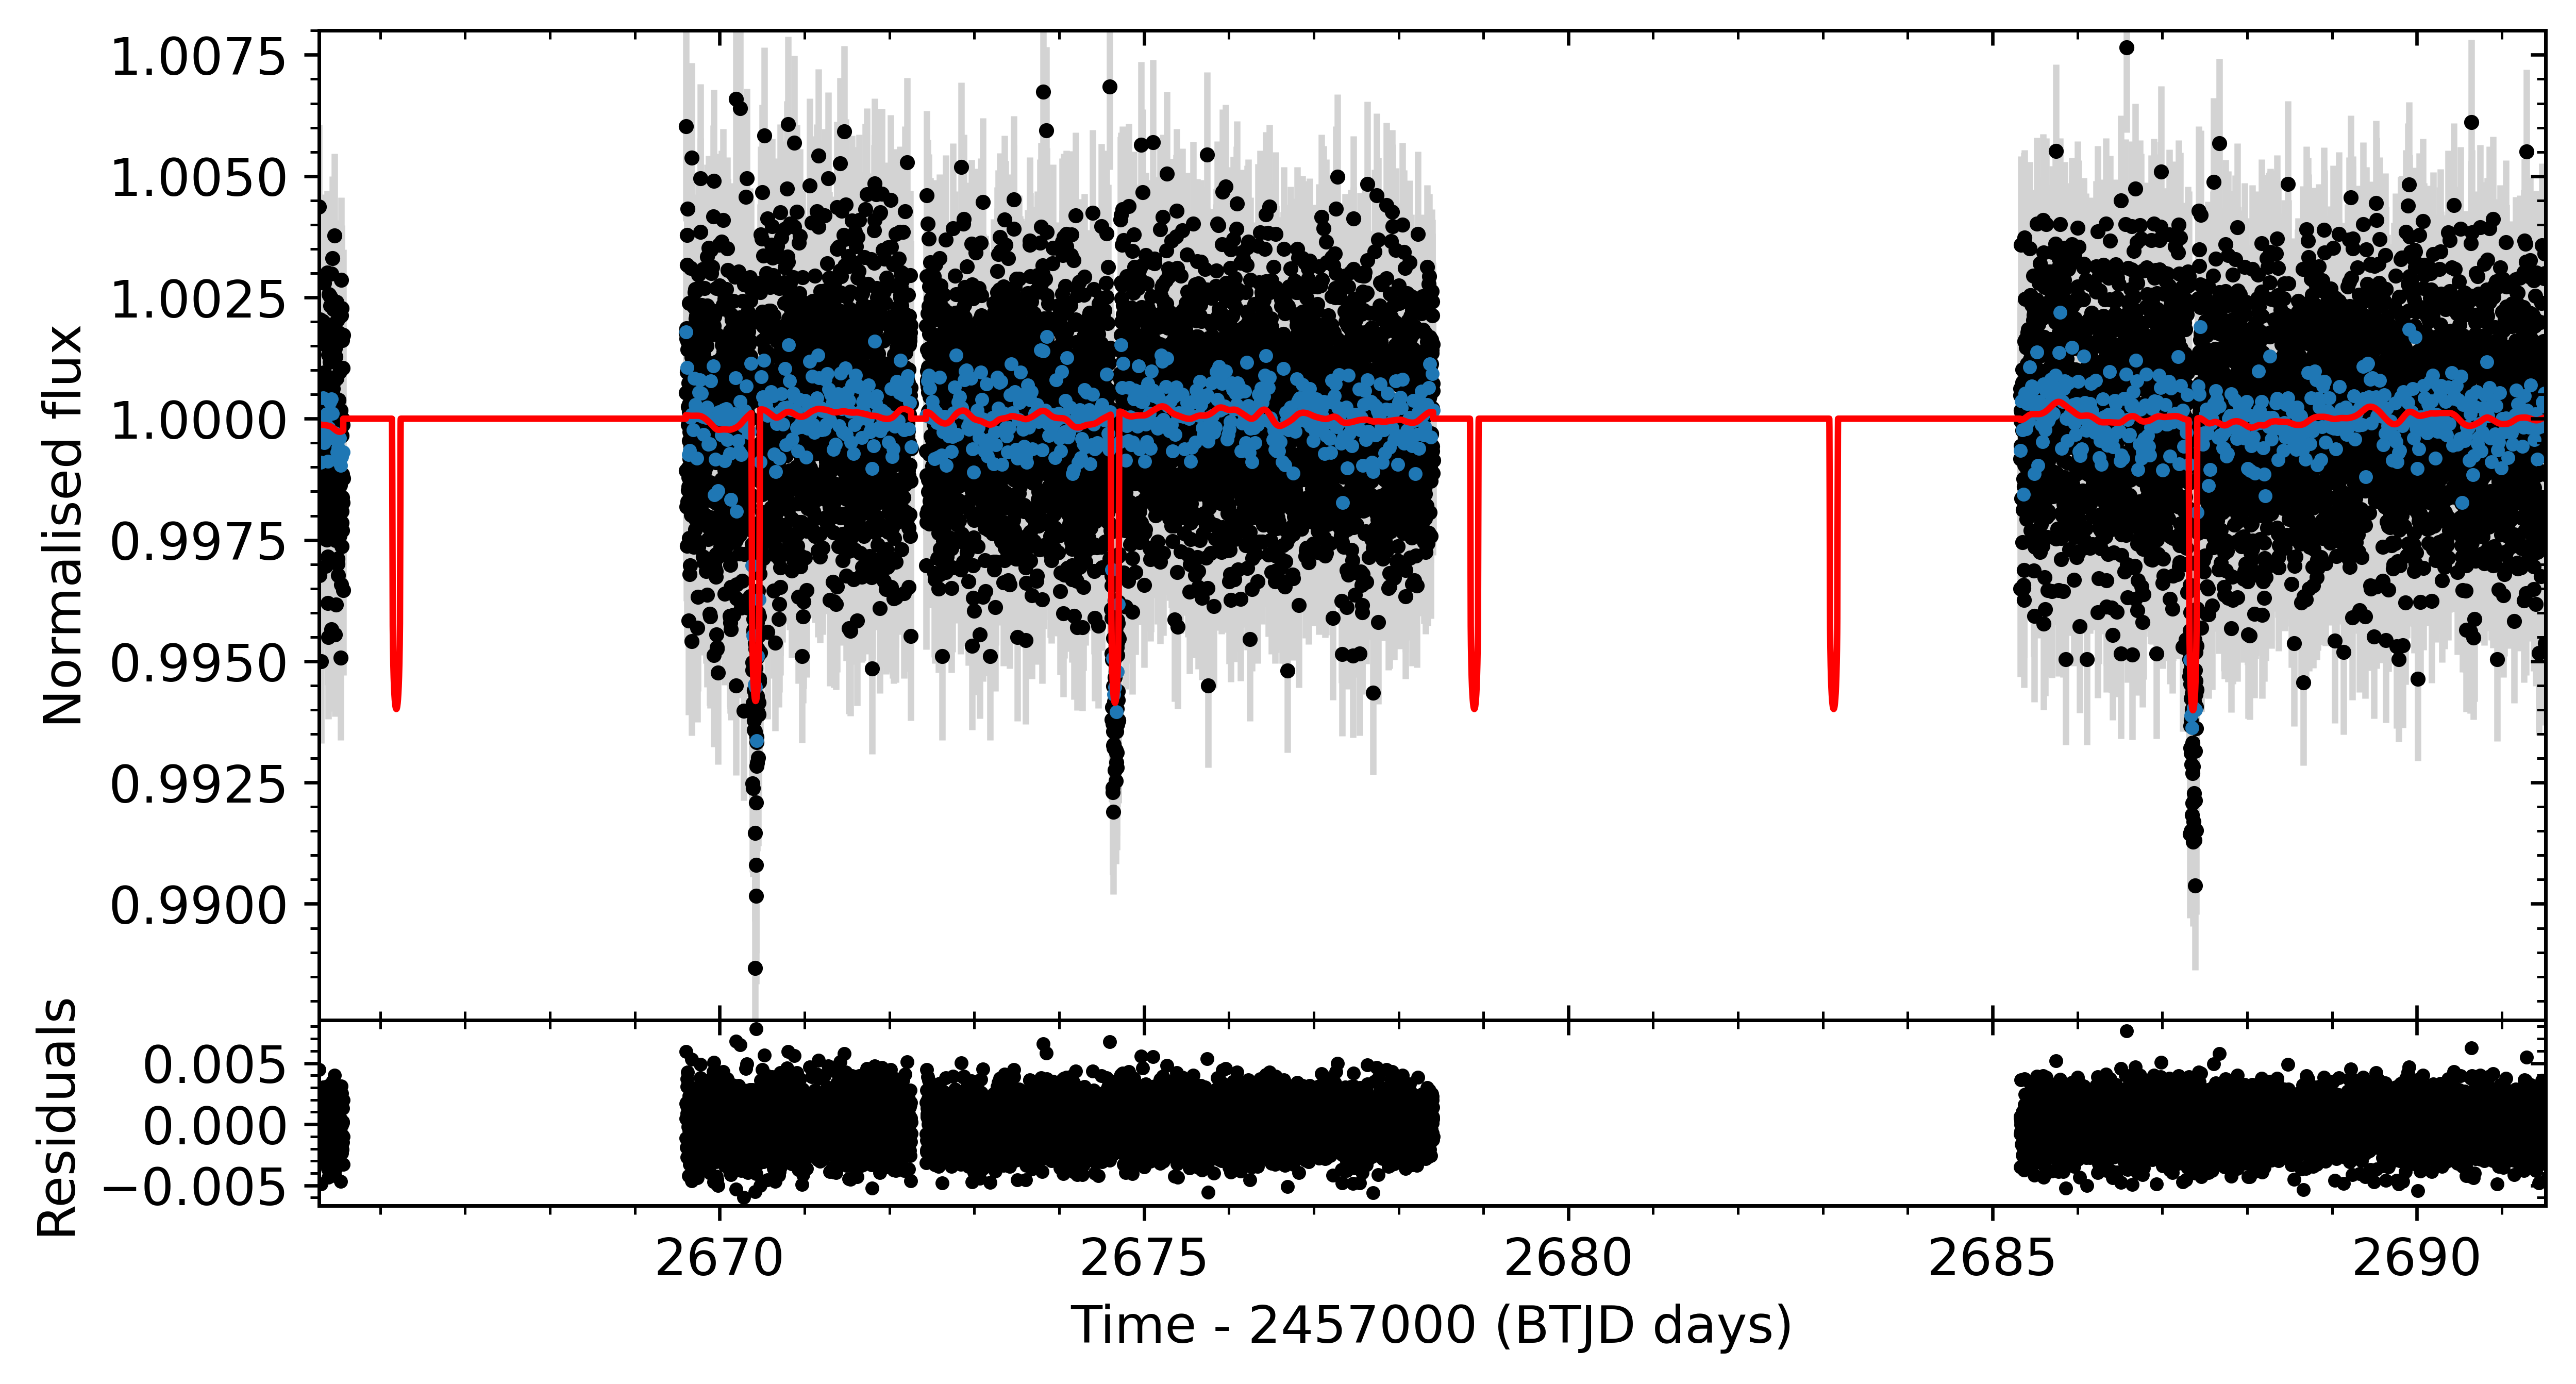

In [53]:
fontsize = 12

#Panel settings
left = 0.1
bottom = 0.1
width = 0.6
height = 0.8
spacing = -0.95
hspacing = 0.01

rect1 = [left, bottom, width, height]
rect_residuals1 = [left, bottom+height+spacing, width, 0.15]

#batman + gp model
ylim = [0.9876, 1.008]
fig = plt.figure(figsize=(12, 4), dpi=600)
ax = fig.add_axes(rect1)
ax2 = fig.add_axes(rect_residuals1)

ax.errorbar(t, flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0) #Black
ax.scatter(lc_binned_time, lc_binned_flux, s=5, zorder=5)
ax.plot(new_model_t, new_model_flux, color='Red', zorder=10)


ax.set_xlim([min(t), max(t)])
ax.set_ylim(ylim)
ax.set_ylabel("Normalised flux", size=fontsize)
# ax.set_xlabel("Time - 2457000 (BTJD days)", size=fontsize)
ax.get_xaxis().set_ticklabels([])
ax.tick_params(axis="x", which="both", direction="in")

# Mirror y
axy = ax.twinx()
axy.set_ylim(ax.get_ylim())
axy.get_yaxis().set_ticklabels([])
axy.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
axx = ax.twiny()
axx.set_xlim(ax.get_xlim())
axx.get_xaxis().set_ticklabels([])
axx.tick_params(which="both", direction="in")

ax.xaxis.set_tick_params(labelsize=fontsize)
ax.yaxis.set_tick_params(labelsize=fontsize)

#Enabling Minor ticks
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
axx.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
axy.yaxis.set_minor_locator(tck.AutoMinorLocator())

"""
Residuals
"""
ax2.scatter(t, residuals, color="black", s=5)
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel("Time - 2457000 (BTJD days)", size=fontsize)
ax2.set_ylabel("Residuals", size=fontsize)

ax2.xaxis.set_tick_params(labelsize=fontsize)
ax2.yaxis.set_tick_params(labelsize=fontsize)

# Mirror y
ax2y = ax2.twinx()
ax2y.set_ylim(ax2.get_ylim())
ax2y.get_yaxis().set_ticklabels([])
ax2y.tick_params(which="both", direction="in")

# Mirror x
ax2x = ax2.twiny()
ax2x.set_xlim(ax.get_xlim())
ax2x.get_xaxis().set_ticklabels([])
ax2x.tick_params(which="both", direction="in")

ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2x.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2y.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.show()